In [1]:
!pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install fastai==2.6.3 --no-deps
!pip install self_supervised

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.9/197.9 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.4
    Uninstalling fastai-2.7.4:
      Successfully uninstalled fastai-2.7.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 441.9 kB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 2.5 MB/s eta 0:00:00a 0:00:01


In [2]:
import fastai
import self_supervised
import torch
fastai.__version__ #Check that version is 2.6.3

'2.6.3'

In [ ]:
#This is not needed unless running SBT
#!pip uninstall --yes git+https://github.com/hamish-haggerty/SVGD_packages.git#egg='Base_Stein'
!pip install git+https://github.com/hamish-haggerty/SVGD_packages.git#egg='Base_Stein'

In [3]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import inspect
import warnings
import random
import math
warnings.filterwarnings("ignore")
#from Base_Stein.SVGD_classes import *

In [4]:
#Like most other SSL algorithms BT's model consists of an encoder and projector (MLP) layer.
#Definition is straightforward:
#https://colab.research.google.com/github/KeremTurgutlu/self_supervised/blob/master/nbs/14%20-%20barlow_twins.ipynb#scrollTo=1M6QcUChcvpz
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):self.encoder,self.projector = encoder,projector
        
    def forward(self,x): return self.projector(self.encoder(x))

In [5]:
#HOWEVER instead of directly using the above, by passing both an encoder and a projector, create_barlow_twins_model
#function can be used by minimally passing a predefined encoder and the expected input channels.

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 

#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

#Similar to above. Simple API to make the BT model:

In [6]:
#BarlowTwins Callback
#The following parameters can be passed:
# - aug_pipelines
# Imb lambda is the weight for redundancy reduction term in the loss function

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)

In [ ]:
#A random degree 2 polynomial, of the form a*x^2 + b*x, where a and b are in {-1,1}, {-1,0,1} respectively
def random_poly(A):
    coeff1 = random.choice([-1,0,1])
    coeff2 = random.choice([-1,1]) #degree 2 term
    B = coeff1*A + coeff2*A.pow(2) 
    return B
    

In [44]:
# #Ok, we want to sample several random polynomials according to some procedure and plot on range [-5,5], or something.
# #This is also just good practice with plotting etc...

def random_quintic(A):

    
    B=torch.normal(mean=0, std=0.125, size=(1, 1)).item() #First Horner term (and is coefficient of x^4)
    
    Btem=torch.normal(mean=0, std=0.25, size=(1, 1)).item()#Sample coefficient of x^3
    B = Btem + B*A #Second Horner term
    
    Btem = torch.normal(mean=0,std=0.5, size=(1, 1)).item() #Sample coefficient of x^2
    B = Btem + B*A #Third Horner term
    
    Btem = random.choice([-1,1])*torch.normal(mean=1,std=2, size=(1, 1)).item() #Sample coefficient of x
    B = Btem + B*A #Fourth Horner term
    
    Btem = torch.normal(mean=0,std=1, size=(1, 1)).item() #Sample coefficient of x^0
    B = Btem + B*A #Fifth Horner term
    
    
    return B



#Ok, we want to sample several random polynomials according to some procedure and plot on range [-5,5], or something.
#This is also just good practice with plotting etc...

#Approx linear quintic
# def random_quintic(A):

    
#     B=torch.normal(mean=0, std=0.01, size=(1, 1)).item() #First Horner term (and is coefficient of x^4)
    
#     Btem=torch.normal(mean=0, std=0.01, size=(1, 1)).item()#Sample coefficient of x^3
#     B = Btem + B*A #Second Horner term
    
#     Btem = torch.normal(mean=0,std=0.025, size=(1, 1)).item() #Sample coefficient of x^2
#     B = Btem + B*A #Third Horner term
    
#     Btem = random.choice([-1,1])*torch.normal(mean=1,std=0.05, size=(1, 1)).item() #Sample coefficient of x
#     B = Btem + B*A #Fourth Horner term
    
#     Btem = torch.normal(mean=0,std=1, size=(1, 1)).item() #Sample coefficient of x^0
#     B = Btem + B*A #Fifth Horner term
    
    
#     return B

In [45]:
def random_sinusoid(x,std=2.0):
    
    t=torch.normal(mean=0,std=std,size=(1,1)).item()
    s=torch.normal(mean=0,std=std,size=(1,1)).item()
    
    u=torch.normal(mean=0,std=std,size=(1,1)).item()
    v=torch.normal(mean=0,std=std,size=(1,1)).item()
    
    return torch.sin(t*x+s) + torch.cos(u*x + v)

In [46]:
def poly_sinusoid(x):
    
    return random_quintic(x) + random_sinusoid(x,std=1)

In [ ]:
def random_quad(A):
    coeff1 = Unif(-2,2)
    coeff2 = Unif(-2,2) #degree 2 term
    B = (coeff1*A + 0.5*coeff2*A.pow(2))
    return B

In [ ]:
def random_quad_new(A):
    coeff2 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term
    coeff1 = torch.normal(mean=1, std=0.2, size=(1, 1)).item() #degree 2 term
    
#     coeff2 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term
#     coeff1 = torch.normal(mean=1, std=0.7, size=(1, 1)).item() #degree 2 term

#     coeff2 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term
#     coeff1 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term
    
    B = (coeff1*A + coeff2*A.pow(2))
    return B

In [ ]:
def random_quad_new2(A):
    power=Unif(1,2.5)
    coeff2 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term
    coeff1 = torch.normal(mean=1, std=1, size=(1, 1)).item() #degree 2 term
    
#     coeff2 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term
#     coeff1 = torch.normal(mean=1, std=0.7, size=(1, 1)).item() #degree 2 term

#     coeff2 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term
#     coeff1 = torch.normal(mean=0, std=1, size=(1, 1)).item() #degree 2 term

    
    B = (coeff1*A + coeff2*torch.abs(A).pow(power))
    return B

In [ ]:
#squared exponential kernel for the GP
def norm2(X):
    """"Vectorized implementation of norm squared. X is collection of N x,y points, and
        returns Y, where Y[i,j] = norm(X[i],X[j])**2. X has shape N*zdim, Y has shape NxN.
    """

    #Use formula ||(x-y)||**2 = ||x||**2 + ||y||**2 - 2x.T*y. in 1d this is just the
    #familiar formula (x-y)**2 expanded.

    X_norm = torch.sum(X ** 2, axis = -1) #gives x[i]**2 for each i

    #This First part is "matrix mult" viewed as addition
    tem1 = X_norm[:,None] + X_norm[None,:] #gives x[i]**2 + x[j]**2 for each i,j

    tem2 = - 2 * torch.mm(X, X.T) #last part of above formula

    return tem1 + tem2


def rbf(NORM2,sig=1.0):
    """"Assumes have already computed norm2(X). So can call as: rbf(norm2(X),sig)
    """

    assert(sig>0)
    assert NORM2.shape[0] == NORM2.shape[1]

    return torch.exp(-1/(2*sig)*NORM2)

In [ ]:
def GP(X,sig=1.0):
    """"x is a set of datapoints"""
    
    
    bs,N=X.shape
    I=1e-5*torch.eye(N).to('cuda')
    Mu = torch.zeros(N).to('cuda')
    MVN = torch.distributions.multivariate_normal.MultivariateNormal
    
    
    for i in range(bs):
        x=X[i,:]
        NORM2=norm2(x.view(-1,1))
        Cov = rbf(NORM2,sig=sig) + I
        mvn=MVN(Mu,Cov)
    
        X[i,:] = mvn.sample()
        
    
    return X

In [ ]:
#Uniform random number between a and b
def Unif(a,b):
    return (b-a)*torch.rand(1).item()+a

In [48]:
#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        
        #Uncomment to run standard BT
    
#     def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
#         bs,nf = pred.size(0)//2,pred.size(1)

#         z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

#         z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
#         z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
#         C = (z1norm.T @ z2norm) / bs 
#         cdiff = (C - self.I)**2
#         loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
#         return loss


    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        bs,nf = pred.size(0)//2,pred.size(1)

        #All standard, from BT
        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2
    
        polyprob=1
        #polyprob=0.5
        temrand = random.random()
        if temrand < polyprob: #With some probability we want off diag terms to be (quadratic) say.

            #This block is "best so far"
#             z1norm_2 = 0.5*z1norm.pow(2)
#             z2norm_2 = z2norm

#             s=Unif(0,0.2)
#             z1norm_2 = (1/s)*torch.sin(s*z1norm)
#             z2norm_2 = z2norm
            
            z1norm_2 = poly_sinusoid(z1norm)

            z2norm_2 = z2norm


#             s=Unif(-2,2)
# #             t=Unif(-1,1)
#             z1norm_2 = (1/(abs(s)))*(torch.sin(s*z1norm))
#             z2norm_2 = z2norm

            C_2 = (z1norm_2.T @ z2norm_2) / bs
            
            cdiff_2 = (C_2)**2 #don't need to subtract I as only looking at off diag terms
            
        else:
            cdiff_2 = cdiff
            
            
            
            
       #New CCA hacking block....
        C1 = (z1norm_2.T @ z1norm_2) / bs 
        C2 = (z2norm_2.T @ z2norm_2) / bs
        
        eps=1e-4
        
        L1, Q1 = torch.linalg.eigh(C1 + eps*self.I)
        L2, Q2 = torch.linalg.eigh(C2 + eps*self.I)
        
        C = (z1norm_2.T @ z2norm_2) / bs
        
        L1=torch.abs(L1)
        L2=torch.abs(L2)
        
        
        C_1 = Q1 @ torch.diag(L1.pow(-0.5)) @ Q1.T #This is 
        C_2 = Q2 @ torch.diag(L2.pow(-0.5)) @ Q2.T
        S = C_1 @ C @ C_2
        [A,D,B]=torch.linalg.svd(S)
        print(D)
        input('hi')     
            
            
            
            
        l2 = cdiff_2*(1-self.I)*self.lmb #Is either the standard term - or not.

        loss = (cdiff*self.I + l2).sum() 
        return loss

    
    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [54]:
#new cell
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)

    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        bs,nf = pred.size(0)//2,pred.size(1)

        #All standard, from BT
        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        C1 = (z1norm.T @ z1norm) / bs 
        C2 = (z2norm.T @ z2norm) / bs
        
        eps=1e-4
        
        L1, Q1 = torch.linalg.eigh(C1 + eps*self.I)
        L2, Q2 = torch.linalg.eigh(C2 + eps*self.I)
        
        C = (z1norm.T @ z2norm) / bs
        
        cdiff = (C - self.I)**2
        
        C1_off = (1-self.I)*(C1**2)
        C2_off = (1-self.I)*(C2**2)
        
        #Drive off diag terms of crosscorrelation matrices towards zero
        Csquare = (1-self.I)*(C**2) #Redundancy reduction term. Same as BT
        
        #Drive autocorrelation matrices towards each other
        AutoCorrel = (C1-C2)**2 #"Invariance" term (also has some redun - reduc built in)
        
        #Difference between largest and smallest eigenvalue

#         E1 = (L1[nf-1]-L1[0]).pow(2)
#         E2 = (L2[nf-1]-L2[0]).pow(2)
        
        tem1=[2*i for i in range(250)]
        tem2=[2*i+1 for i in range(250)]
        
        
        Diff = (L1[tem1] - L1[tem2]).pow(2) +  (L2[tem1] - L2[tem2]).pow(2)
        
        
        #CCA: Formula from here:https://civil.colorado.edu/~balajir/Adv-Data-material/CVEN-6833/papers-2read/Cherry_2003.pdf
        C_1 = Q1 @ torch.diag(L1.pow(-0.5)) @ Q1.T #This is 
        C_2 = Q2 @ torch.diag(L2.pow(-0.5)) @ Q2.T
        S = C_1 @ C @ C_2
        
        [A,D,B]=torch.linalg.svd(S)
        
        loss_CCA = (D[0]-1).pow(2) + D[1]
      
        
        
#         Err1=0
#         Err2=0
#         PC=5
        
#         for i in range(1,PC):
#             Err1 += L1[nf-i]*Q1[:,nf-i].view(-1,1) @ Q1[:,nf-i].view(1,-1)
#             Err2 += L2[nf-i]*Q2[:,nf-i].view(-1,1) @ Q2[:,nf-i].view(1,-1)
            
#         Err=(Err1-Err2).pow(2)
        
#         #i.e. we want 500th-99th eigenvalues to be small
#         Err_sparse = L1[0:nf-PC].pow(2) + L1[0:nf-PC].pow(2)

        #Drive autocorrelation matrices away from zero
        #s=Unif(0.05,0.25)
        #s=0.5
        gamma=1
        #s=Unif(0,1)
        
        #C1_NoCollapse = (1-self.I)*((abs(C1)-s)**2) 
        #C2_NoCollapse = (1-self.I)*((abs(C2)-s)**2)
        
        relu = torch.nn.ReLU()
        eps=1e-6

        
        #Replace squared error with hinge loss
#         C1_NoCollapse = (1-self.I)*(relu(s-torch.abs(C1)))
#         C2_NoCollapse = (1-self.I)*(relu(s-torch.abs(C2)))

        #Prevent collapse to zero - this is mean to be like term from VicReg but haven't 
        #tested it carefully...
        V1 = (self.I*(relu(gamma-C1)) + eps).pow(0.5)
        V2 = (self.I*(relu(gamma-C2)) + eps).pow(0.5)
        
        
        #cdiff same as BT. AutoCorrel is new, instead of redun reduc term...
        
        
        #So this is BT plus the autocorrel term, plus NoCollapse terms and with appropriate rescaling
        #loss = (self.I*cdiff).sum() + self.lmb*(0.5AutoCorrel.sum())#+0.5*Csquare.sum())# + self.lmb*0.05*(C1_NoCollapse.sum() + C2_NoCollapse.sum())   #+ 0.5*Csquare.sum() + 0.1*(C1_NoCollapse.sum() + C2_NoCollapse.sum()))#*(1/nf)
        #loss = self.lmb*(AutoCorrel.sum())+self.lmb*0.05*(C1_NoCollapse.sum() + C2_NoCollapse.sum())#+0.5*Csquare.sum())# + self.lmb*0.05*(C1_NoCollapse.sum() + C2_NoCollapse.sum())   #+ 0.5*Csquare.sum() + 0.1*(C1_NoCollapse.sum() + C2_NoCollapse.sum()))#*(1/nf)
        
        #loss = self.lmb*(AutoCorrel.sum())+0.5*(V1.sum() + V2.sum())
        
        #loss = (1/(nf*(nf-1)))*(AutoCorrel.sum()) + 0.5*(V1.mean() + V2.mean())
        
        #0.8102
        
        eig1=L1[nf-1]
        eig2=L2[nf-1]
        
        
        loss = loss_CCA+(1/100)*(V1.sum() + V2.sum())
        

        #loss = self.lmb*(AutoCorrel.sum()) + eig1 + eig2+ 1/nf*Diff.sum() + (1/10)*(V1.sum() + V2.sum())
        
        #loss = (1/nf)*((L1-L2).pow(2).sum() + (L1.sum()+L2.sum()) + (V1.sum() + V2.sum()))
        
        #loss = (1/nf)*(self.lmb*Err.sum()  + 0.5*(Err_sparse.sum()+Err_sparse.sum()) + 0.5*(V1.sum() + V2.sum()))

        #cdiff = (C - self.I)**2
        #loss = (cdiff*self.I + 0.5*self.lmb*cdiff2 + 0.5*cdiff*(1-self.I)*self.lmb).sum()# + cdiff*(1-self.I)*self.lmb).sum() 
        return loss


    
    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [55]:
#Debugging cell - delete later (similar to cell below)
ps=500
hs=500
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=hs,projection_size=ps)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=True)
#learn = Learner(dls, model,ShortEpochCallback(0.001), cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn.fit(1000)#300   


Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


epoch,train_loss,valid_loss,time
0,6.000460,6.000420,00:01
1,6.000463,6.001883,00:01
2,6.000467,6.000453,00:01
3,6.000463,6.000458,00:02
4,6.000467,6.000429,00:01


KeyboardInterrupt: 

In [8]:
#Get the dataloader and set batch size
ts=512 #training set size
bs=256
device='cuda'
path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
items=items.shuffle()

items1 = items[0:ts]
split = RandomSplitter(valid_pct=0.5) #randomly split training set into training and validation
#tds = Datasets(items,splits=split(items)) #Do we want this?
tds = Datasets(items1, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items1)) #Or do we want this?
dls = tds.dataloaders(bs=bs, after_item=[ToTensor(), IntToFloatTensor()], device=device)

#Evaluate linear classifier on this guy
items2 = items[ts:]
split = RandomSplitter(valid_pct=0.99) #randomly split training set into training and validation
tds_new = Datasets(items2, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items2)) #Or do we want this?
dls_new = tds_new.dataloaders(bs=bs, after_item=[ToTensor(), IntToFloatTensor()], device=device)


In [ ]:
tem = [str(i) for i in items1]

t = [j.split('training/')[1] for j in tem]
t = [j.split('/')[0] for j in t]

d={'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}


for i in t:
    d[i]=d[i]+1
    
print(d)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


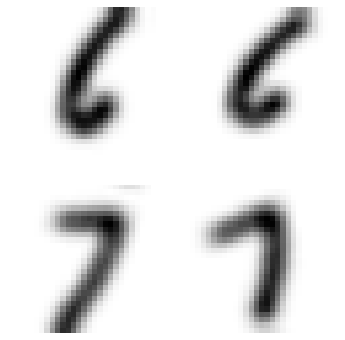

In [9]:
#A "reasonable" composite augmentation: initially copy pasted BT. We run this cell a few times to check it makes sense
#Also define encoder and model
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=False)
#learn = Learner(dls, model,ShortEpochCallback(0.001), cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])

#dls.valid.bs = len(dls.valid_ds) #Set the validation dataloader batch size to be the length of the validation dataset

b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=2)

In [10]:
#Simple linear classifier
class LinearClassifier(nn.Module):
    
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,10) #As 10 classes for mnist
        
    def forward(self,x):
        x = cast(self.fc1(x),Tensor) #so we have to use cross entropy loss. cast is because using old version fastai 
        return x

In [ ]:
#Train Classifier on encoder(mnist) for (at the moment) one epoch

fastai_encoder.eval()

zdim=1024 #see above
head = LinearClassifier(zdim=zdim)
device='cuda'
head.to(device)
optimizer = torch.optim.Adam(head.parameters())
criterion = nn.CrossEntropyLoss()
#EPOCHS=100

for epoch in range(100):
    for x,y in dls.train:
        #break 
        #b = dls.train.one_batch() #Seems need dls[0] or dls.train for training ... dls[1] is validation see here https://docs.fast.ai/data.core.html#DataLoaders.__getitem__
        #x,y = b[0],b[1]

        loss = criterion(head(fastai_encoder(x)),y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print(loss)
print('done')
        

In [ ]:
#Test result of above cell on the validation set - assumes that batch size of valid-dataloader is = number of valid samples                                        

# print('The validation batch size is: {} '.format(dls.valid.bs))
# input()

#b = dls.valid.one_batch()

fastai_encoder.eval()

num_correct=0
for x,y in dls_new.valid:
    ypred = head(fastai_encoder(x))
    correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
    num_correct += correct.sum()
print(num_correct/len(dls_new.valid_ds))

#0.9168 - 400 epochs, poly_sinusoid (need to uncomment random_quintic top part)
#quite good results on only 400 epochs. 

Results for poly_sinusoid - see above for the present implementation of quintic/sinusoid/poly_sin 

Base HPs as before: ts=512,bs=256, ps=hs=500,pp=1, learn_epochs=1000, tune_epochs=100.

**Run_1: 0.9294, Run_2: 0.9181, Run_3: 0.9233, Run_4: 0.9253, Run_5:0.9192,Run_6: 0.9243  
Mean: 0.9233**

Comments: This is with poly_sinusoid implemented as above (for this commit). This is best so far (but basically equal results to "random_quad_new2" -> see the cell below)



Further results for Quad_Normal - experimenting to find best polynomial
Base HPs are: ts=512,bs=256, ps=hs=500,pp=1, learn_epochs=1000, tune_epochs=100
Specific HPs: power = Unif(1,3), coeff2 = N(0,1), coeff1=N(1,0.2)  
Run_1: 0.9193, Run_2: 0.9105.   After two runs average is basically same as below average. So, let's try varying specific HPs  

Namely, let's make power Unif(1/3,2.5) instead of Unif(1,3). Keep everything else same. 
Specific HPs: power = Unif(1/3,2.5), coeff2 = N(0,1), coeff1=N(1,0.2)  
Run_2: 0.9057 (bit worse than above)  

Let's make power=max(0.1,N(2,0.25))

Run_2: 0.8854 (definitely worse than above)

**NEW random sample**

Specific HPs: power = Unif(1,2.5), coeff2 = N(0,1), coeff1=N(1,1)  
**Run_1: 0.9210, Run_2: 0.9161, Run_3: 0.9184, Run_4: 0.9233, Run_5: 0.9263
Average: 0.92102**

Comments: See random_quad_new2 above (this was the function used)

Further results for MNIST: Quad_normal seems slightly better


First the hps are:

HPs are: ts=512,bs=256, ps=hs=500,pp=1, learn_epochs=1000, tune_epochs=100, std=0.7. Note: std for Quad_normal=std=0.7 or 0.2. Not actually sure here. 

Imp note: since we split with 0.5 to training and validation, the training set size is actually 256 (this is a "bug" with what we have been doing...)

So we are using a training set of 512, batch size of 256, (to try and make it "harder" so we can actually discriminate better between the models / see if there is actually a difference). Also increased latent size to 500, since from the paper, BT requires large latent dimension to work well.  1000 learn epochs and 100 tune epochs.

**BT, run_1: 0.8864, run_2: 0.8950, run_3: 0.9053, run_4: 0.9049, run_5: 0.9033
Quad_normal, run_1: 0.9103,run_2: 0.9075  run_3: 0.9205, run_4: 0.9081, run_5: 0.9313**  

Comments: 

After 5 runs, BT mean performance was 0.89898 with SD=0.008181 and Quad_normal was 0.91554 with SD=0.010252. Quad_normal is 1.018% better and outperformed BT on each run

Validation loss on Quad_normal run_2 jumped from ~25 on prior epochs to 78.8 on last - still did a touch better than BT anyway.




Background we are performing ablations on the Barlow twins loss function: Instead of the $\operatorname{Corr}(z_{i}^A,z_{j}^B)=0$ constraints, we 
have a constraint $\operatorname{Corr}(z_{i}^A,p(z_{j}^B))=0$, where $p$ is a random polynomial (sampled for each batch). Motivation: The $\operatorname{Corr}(z_{i}^A,z_{j}^B)=0$, constraint in BT is a redundancy reduction term. Really want these terms to be statistically independent, not just uncorrelated. It is a theorem that if $\operatorname{Corr}(h(X),h(Y))=0$ for all $h$ in a suitable class of functions (e.g. continuous functions) THEN $X$ and $Y$ are independent.

Setup: there are two steps, a self supervised phase (with no labels) and a supervised phase (to test the quality of the representation learned): Step 1 - the SSL phase:  We train BT (and the modified BT) on 256 unlabelled MNIST samples for 1000 epochs, with a latent dimension size of 500. Step 2: Then we take the frozen representation learned, and fine tune a linear classifier on top of it (using the same 256 samples - this time with the labels).  i.e. we train a linear classifier on a frozen 500 dimensional input, which is the latent representation learned through the self supervised learning procedure. From the point of view of the second step, we are just training a linear model with a 500 dimensional input, and ten output categories. After the linear model is trained, we evaluate it on remaining ~ 59k MNIST samples for accuracy. We repeat this whole procedure 5 times (with different random 256 training samples each time).

Last week kept experimenting with ways of sampling $p$. Have found that low degree works ok, higher degree degrades performance. We sample $p$ according to: $ax + bx^2$, where $a \sim \mathcal{N(1,0.2)}$ and $b \sim \mathcal{N(0,1)}$. So a typical sample might look like: $p(x)=1.18x + 1.7x^2$

With this setup, results from the 5 runs (different 256 samples for each run_i, and trained BT and Modified on these samples)

BT, run_1: 0.8864, run_2: 0.8950, run_3: 0.9053, run_4: 0.9049, run_5: 0.9033

Modified BT, run_1: 0.9103,run_2: 0.9075  run_3: 0.9205, run_4: 0.9081, run_5: 0.9313

Comments: Mean performance of BT is 89.90% and Modified is 91.55%. Modified beat BT on each run, with the biggest gap being 90.33% vs 93.13%.

When tried sampling a larger degree polynomial, even degree 3 causes performance to degrade. When tried sampling $p$ from some other class of continuous functions, e.g. sinusoids, performance degraded. 

** Really want a more principled way of sampling $p$ ** 





Further results for MNIST:

Background we are performing ablations on the Barlow twins loss function: Instead of the $\operatorname{Corr}(z_{i}^A,z_{j}^B)=0$ constraints, we 
have a constraint $\operatorname{Corr}(z_{i}^A,p(z_{j}^B))=0$, where $p$ is a random polynomial (sampled for each batch). Motivation: The $\operatorname{Corr}(z_{i}^A,z_{j}^B)=0$, constraint in BT is a redundancy reduction term. Really want these terms to be statistically independent, not just uncorrelated. It is a theorem that if $\operatorname{Corr}(h(X),h(Y))=0$ for all $h$ in a suitable class of functions (e.g. continuous functions) THEN $X$ and $Y$ are independent.


Baseline: Train BT on 1024 (unlabelled) MNIST samples (around 1.67% of the available training data), to learn a representation (100 dimensional). Then take the frozen representation, and on the same samples train a linear classifier head (with the labels). Evaluate on ~58k MNIST samples. Result: 92.91% accuracy

Modified method: After experimentation, best result so far was sampling $p$ as $p(x)=\frac{1}{2} x^2$ with probability $0.25$ or $p(x)=x$ with probability $0.75$. With same procedure as above, result: 93.44% accuracy. A tiny bit better than 92.91%, but possibly not statistically significant difference.   

Unfortunately, gap between results from last week closed as trained for more epochs (1000). Tried different ways of sampling $p$ between batches, e.g. as a moderate degree polynomial with uniformly random weights $Unif[-1,1]$ but couldn't get this to work - it degraded performance. Conclusion: Even though modified method is motivated, it may not improve on BT for whatever reason... However, since a fairly hacky way of sampling $p$ does work at least as well (actually slightly better) in experiments so far, going to continue experimenting with ways of sampling $p$. Plan with this line of investigation: Keep experimenting, but don't spend 100% of time on it. Need to try using larger latent dimension, as BT tends to require large dimensionality to work (conversely to other SSL methods).

Also exploring alternative ablations of BT loss function. In BT the loss function depends on $C^{AB}$ the cross correlation matrix. Loosely speaking,$L_{BT}$  tries to make this correlation matrix equal to the identity.  It is natural to consider instead the autocorrelation matrices $C^{AA}$ and $C^{BB}$ and a loss function that makes the autocorrelation matrices equal. The idea behind this is that representations $Z^{A}$ and $Z^{B}$ of two distorted views of the same image, should have approximately equal correlations between variables. In order to do this, the representation has to learn to ignore the specific distortions applied to the image. Preliminary results slightly underperform BT. 

Plan for next week:
Keep experimenting, but read more of the literature and explore other SSL papers




Ok let's be a little bit more systematic:

Let's just compare BT to quadratic applied to one variable. i.e. $\frac{1}{2} x^2$ and $y$. 
Hyperparameters: ts=1024,bs=128, ps=hs=100,pp=0.25, learn_epochs=300, tune_epochs=100

Results (different random ts each time, i.e. for each run)

Run_1: BT=0.8784, QUAD_1var = 0.8633 (last validation loss was a bit high though)  
Run_2: BT=0.8788, QUAD_1var = 0.8891 (opposite to above line - last validation loss dropped a lot compared to prior few)
Run_3: BT=0.8695, QUAD_1var = 0.8589

Comments: Ok, this looks like typical variation. Sometimes BT a little better, sometimes quad a little better. On the other hand, validation loss fluctuates A LOT for quad - when it ended on a low value, it did better. So maybe we need to train for more epochs, i.e. "to convergence". 

So, keep everything above the same, except train for 1k learn_epochs. Then get:  
Run_1: BT=0.9291, QUAD_1var = 0.9344, QUAD_2var = 0.9324, New_LF=0.9128, New_LF_normorderflipped = 0.9198 (note that loss started increasing unnaturally at the end - may need to re-run this one)
So quad smidge better, but not clear this is statistically meaningful.

Comments: (After BT): the training loss goes down consistently, more and more slowly as training progresses. Validation loss trends down too, but with VERY large variance. Perhaps this suggests I need to train on a larger number of training samples for BT and instead evaluate by tuning on a small dataset. Training loss ended at 0.3, validation at 1.37 (ending validation loss was ok, but e.g. on the last few epochs had: 2.25,0.75,0.62,1.37; i.e a lot of variance). (After quad): Same comments as before. Validation loss on last few epochs: 0.78, 0.87, 0.9,0.89. (After QUAD_2var - i.e. everything same except we apply quadratic to both variables): Loss doesn't go down as much as for other two methods. Even more variance in CV loss. Last few terms: 3.66,3.51,0.84,0.99.)

What I have learned: Need to train for longer (i.e. "to convergence"). 


New model: (All hps same as above, diff random sample)
Run_1

Preliminary results for MNIST:

We perform some ablations on the Barlow twins loss function: Instead of the $\operatorname{Corr}(z_{1i},z_{2j})=0$ constraints, we 
have a constraint $\operatorname{Corr}(z_{1i},p(z_{2j}))=0$, where $p$ is a random polynomial (sampled for each batch). Motivation: The $\operatorname{Corr}(z_{1i},z_{2j})$ constraint in BT is a redundancy reduction term. Really want these terms to be statistically independent, not just uncorrelated. It is a theorem that if $\operatorname{Corr}(h(X),h(Y))=0$ for all $h$ in a suitable class of functions (e.g. continuous functions) THEN $X$ and $Y$ are independent. 

Baseline: Train BT on 1000 (unlabelled) MNIST samples (around 1.67% of the available training data), to learn a representation (125 dimensional). Then take the frozen representation, and on the same samples train a linear classifier head (with the labels). Evaluate on ~58k MNIST samples. Result: 73.27% accuracy

Modification: We take p to be a low dimensional polynomial. Then training modified BT, (MBT) on the same 1k MNIST samples as above, and evaluating on the remaining ~58k, we get 79.85% accuracy, which is larger than 73.27% for Barlow twins. As a point of comparison, if we train a linear classifier on the raw 28x28 pixels (instead of the frozen representation), accuracy is 60%, so as expected training a linear classifier on a learned representation is superior to training on the raw pixels.

Concerns: Usually these is a mistake, especially when results are positive... Need to test everything carefully. Have been experimenting on MNIST for a while, so need to test on a different dataset, maybe CIFAR or miniImagenet. 

**Plan for next week or so**

* Test above results more carefully by running several times (on different 1k samples each time), and try performing ablations similar to the BT paper. I think it is likely I have made several mistakes, as is typical..
* Importantly: test the above loss function ablations on another dataset to MNIST. 
* Spend ~ 50% of time continuing to read literature. Especially want to read VICReg paper, which builds on BT paper
* Need to improve Latex skills, and in particular learn how to create good graphics / visuals




In [ ]:
#Current hacking:
Baseline_BT=0.7983


In [ ]:
# #Just train a linear classifier (no encoder)
# #Basically cell above but remove encoder and some re-shaping
zdim=500 #see above
head = LinearClassifier(zdim=zdim)
head.to(device)
optimizer = torch.optim.Adam(head.parameters())
criterion = nn.CrossEntropyLoss()


for x,y in dls.train:
    #break
    #b = dls.train.one_batch() #see here https://docs.fast.ai/data.core.html#DataLoaders.__getitem__
    #x,y = b[0],b[1]

    x=x.view(bs,zdim)
    x=cast(x, Tensor) #Have to do this when using old version of fastai for some reason...
    
    out = head(x)
    loss = criterion(out,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [ ]:
# #Test result of above cell, (i.e. just a linear classifier), on the validation set - assumes that batch size of valid-dataloader is = number of valid samples                                        
# num_correct=0
# for x,y in dls_new.valid:

#     x=x.view(x.shape[0],zdim)
#     x=cast(x, Tensor) #Have to do this when using old version of fastai for some reason...
    
#     ypred = head(x)
#     correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
#     num_correct += correct.sum()
    
# print(num_correct/len(dls_new.valid_ds))